# Exploratory Data Analysis for SPAM SMS Data

In [67]:
# import
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
import nltk
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer


In [2]:
## Load Data 
# load the sms data 
data = pd.read_csv('smsspamcollection/spam.csv',encoding=('ISO-8859-1'),usecols=[0,1])
data.columns = ['label','message']

In [3]:
data.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Check of Missing Values 

In [4]:
# Check for Missing values 
data.isna().sum()

label      0
message    0
dtype: int64

In [5]:
data.shape

(5572, 2)

### Label Distribution : Balanced or Imbalanced 

In [7]:
# check the Label Ratio
data.label.value_counts()

ham     4825
spam     747
Name: label, dtype: int64

<AxesSubplot:ylabel='label'>

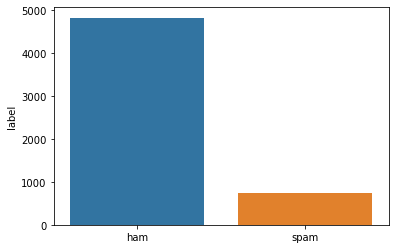

In [8]:
sns.barplot(x=['ham','spam'],y=data.label.value_counts(),)

Obervation: The above graph clearly shows that the dataset is imbalanced, we have very low number of spam messages compared to ham.

### Length of Messages 

In [14]:
data['mlength']= data.message.apply(lambda x:len(x))

In [15]:
data.head()

,label,message,mlength
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


Text(0.5, 1.0, 'SMS Word counts Distribution')

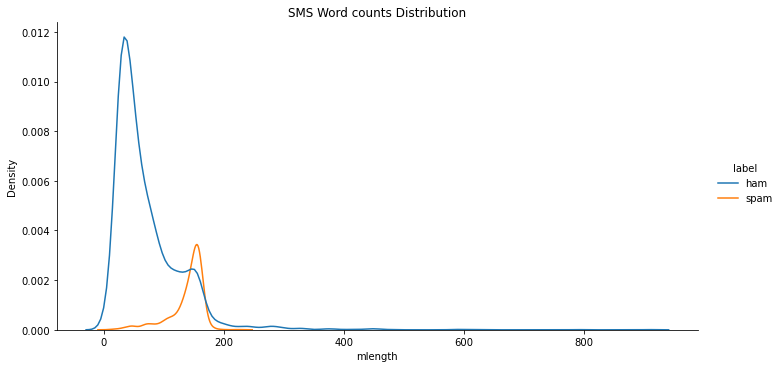

In [20]:
sns.displot(data=data,x='mlength',hue='label',kind='kde',height=5, aspect=2)
plt.title('SMS Word counts Distribution')

Observation: It can be observed that,length of  SPAM messages tend to follow slightly different distribution than the ham messages.

## Data Cleaning 


Data Cleaning At this stage only includes, removal of the puntations.
we would like to see if any special characters appear in the spam sms?

In [168]:
def clean_sentence(message):
    
    lemmatizer = WordNetLemmatizer()
    # Remove all the words execpt words and numbers
    review = re.sub('[^a-zA-Z]',' ',message)
    
    # convert to lower case 
    review =review.lower()
    
    # Tokenize words
    words = nltk.word_tokenize(review)
    
    # remove stop words and lemmatize
    words = [lemmatizer.lemmatize(word) for word in words if word not in set(stopwords.words('english'))]
    
    # rejoin 
    review = ' '.join(words)
    
    return review
    

In [169]:
clean_data = data.copy()

# Clean the data 
clean_data.message = clean_data.message.apply(clean_sentence)

In [170]:
# Re calculate the length of cleaned messages 
clean_data.mlength = clean_data.message.apply(lambda x:len(x))

In [171]:
clean_data.head()

,label,message,mlength
0,ham,go jurong point crazy available bugis n great ...,82
1,ham,ok lar joking wif u oni,23
2,spam,free entry wkly comp win fa cup final tkts st ...,101
3,ham,u dun say early hor u c already say,35
4,ham,nah think go usf life around though,35


In [172]:
data.head()

,label,message,mlength
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


# SPAM and HAM Message Analysis 

In [173]:
# Seperate Spam and ham Data for Analysis

spam_data = clean_data[clean_data.label=='spam']
ham_data = clean_data[clean_data.label=='ham']

### Word count : spam vs ham

Text(0.5, 1.0, 'SMS Word counts Distribution(cleaned data)')

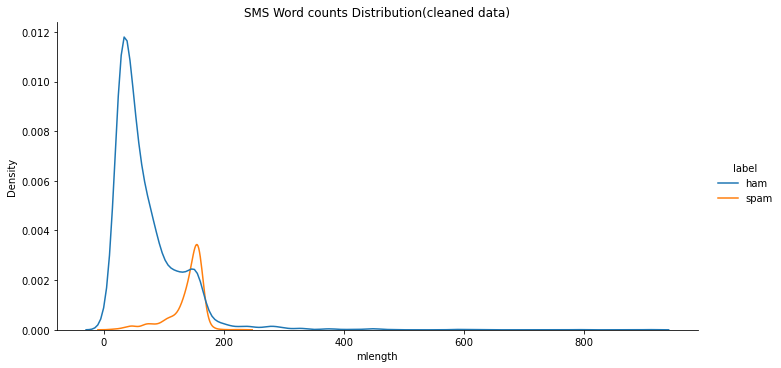

In [174]:
# Plot the word count distribution after cleaning 
sns.displot(data=data,x='mlength',hue='label',kind='kde',height=5, aspect=2)
plt.title('SMS Word counts Distribution(cleaned data)')

In [175]:
spam_data.mlength.describe()

count    747.000000
mean      87.354752
std       22.731531
min        4.000000
25%       77.000000
50%       90.000000
75%      103.000000
max      141.000000
Name: mlength, dtype: float64

In [176]:
ham_data.mlength.describe()

count    4825.000000
mean       43.064249
std        36.173567
min         0.000000
25%        19.000000
50%        32.000000
75%        56.000000
max       442.000000
Name: mlength, dtype: float64

### Word Cloud 

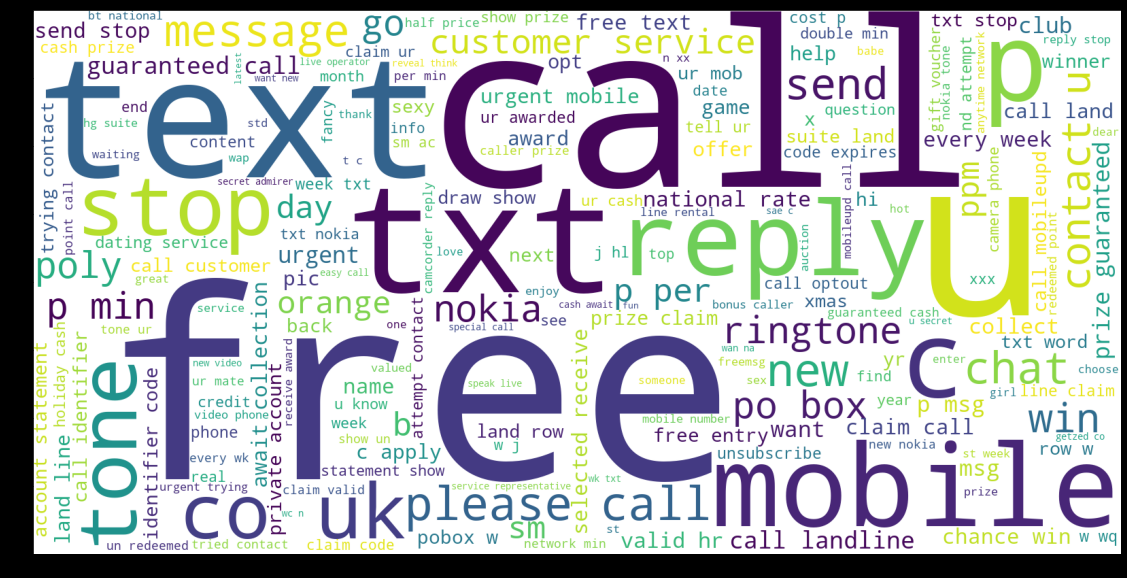

In [177]:
wordcloud = WordCloud(background_color='white',width=1600,height=800).generate(' '.join(spam_data.message.tolist()))
plt.figure(figsize=(20,10),facecolor='k')#
plt.imshow(wordcloud)

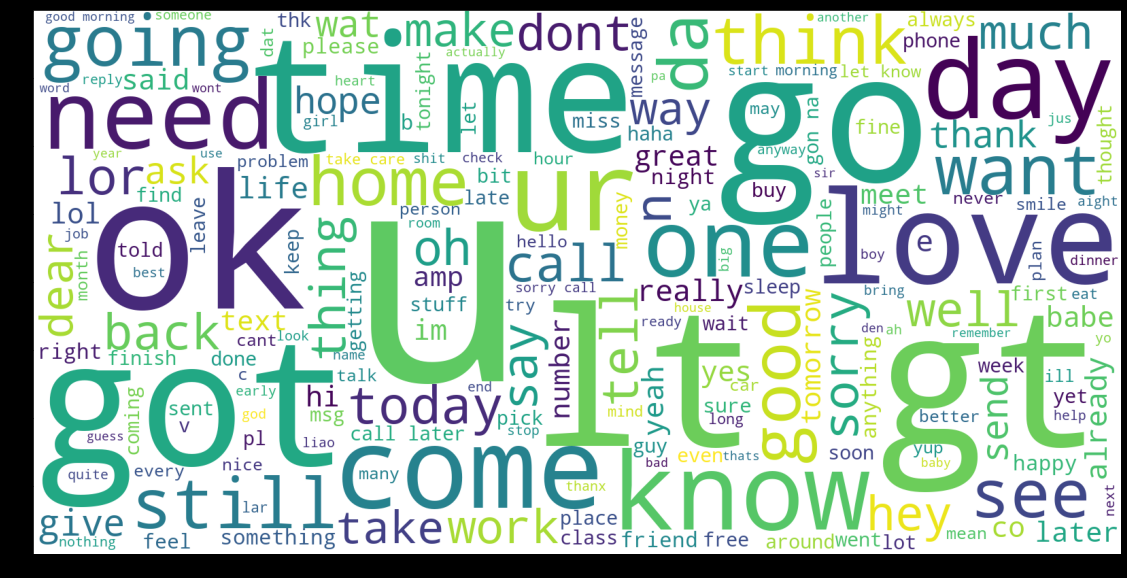

In [178]:
wordcloud = WordCloud(background_color='white',width=1600,height=800).generate(' '.join(ham_data.message.tolist()))
plt.figure(figsize=(20,10),facecolor='k')#
plt.imshow(wordcloud)

### Frequent Words 

In [179]:
# get the top n words in the vocab 

def get_top_n_words(corpus,n=20):
    
    cv = CountVectorizer()
    # genereate spare matrix or Bag of Words
    x_matrix = cv.fit_transform(corpus).toarray()
    
    # Generate total count of each words : sum across the columns in sparse matrix
    word_counts = x_matrix.sum(axis=1)
    #print(word_counts)
    
    # sort the word_counts in Decending order and get the index of top n words
    sorted_index = (-word_counts).argsort()[:n]
    
    # Get Vocab words 
    vocab_words = np.array(cv.get_feature_names())
    
    # Retrieve top n words from vocab_words
    top_n_words = vocab_words[sorted_index]
    
    # Get the counts of the top n words 
    top_n_word_counts = word_counts[sorted_index]
    
    return list(top_n_words),list(top_n_word_counts)


In [180]:
def plot_top_n_words(corpus,title,n=20):
    top_20_words,top_20_wordcounts = get_top_n_words(corpus,n)
    sns.barplot(x= top_20_words,y=top_20_wordcounts)
    plt.title(title)
    plt.xticks(rotation=70)
    plt.tight_layout()  
    

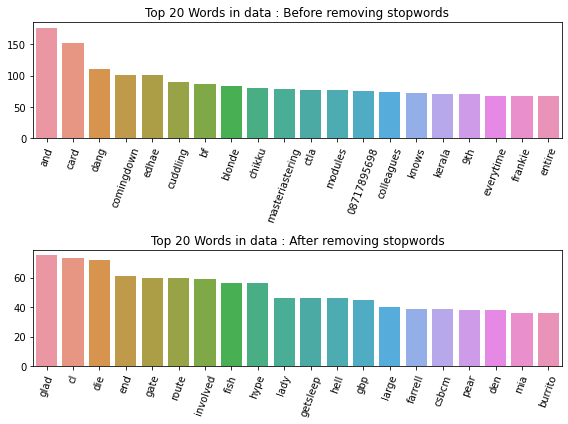

In [181]:
# top 20 Words before  and after Cleaning 
plt.figure(figsize=(8,6))
plt.subplot(2,1,1)
plot_top_n_words(data.message,title='Top 20 Words in data : Before removing stopwords')
plt.subplot(2,1,2)
plot_top_n_words(clean_data.message,title='Top 20 Words in data : After removing stopwords')

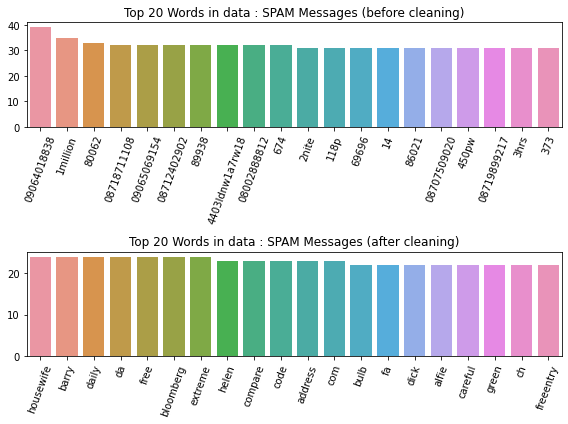

In [183]:
# top 20 Words in spam data 
plt.figure(figsize=(8,6))
plt.subplot(2,1,1)
plot_top_n_words(data.loc[data.label=='spam','message'],title='Top 20 Words in data : SPAM Messages (before cleaning)')
plt.subplot(2,1,2)
plot_top_n_words(spam_data.message,title='Top 20 Words in data : SPAM Messages (after cleaning)')

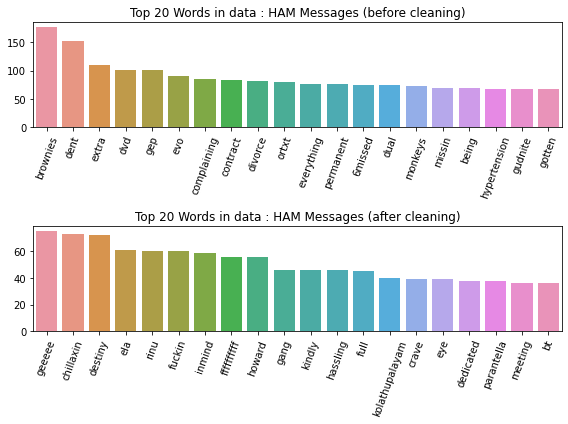

In [184]:
# top 20 Words in spam data 
plt.figure(figsize=(8,6))
plt.subplot(2,1,1)
plot_top_n_words(data.loc[data.label=='ham','message'],title='Top 20 Words in data : HAM Messages (before cleaning)')
plt.subplot(2,1,2)
plot_top_n_words(ham_data.message,title='Top 20 Words in data : HAM Messages (after cleaning)')

In [1]:
from helper_functions import clean_sentence

In [4]:
clean_sentence('i thought something amazing. but its ok::@@#  now , i looking forward to it')

'thought something amazing ok looking forward'